# Transformers Benchmarks

This notebook evaluates BERT and GPT training performance on single and multiple GPUs. 

## Setup

First check environment and all available GPUs.

In [1]:
import torch

print('Pytorch version\t:', torch.__version__)
print('CUDA version\t:', torch.version.cuda)

for i in range(torch.cuda.device_count()):
    print(f'GPU{i}\t\t:',torch.cuda.get_device_name(i))

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pytorch version	: 1.13.0a0+08820cb
CUDA version	: 11.7
GPU0		: Tesla T4
GPU1		: Tesla T4


Next install packages we need beyond pytorch. Note that both deepspeed and megatron-lm need `nvcc` to build custom operators. Make sure you have a complete CUDA installation rather than just runtime. 

In [2]:
from IPython.display import clear_output

!git clone https://github.com/huggingface/transformers
!git clone https://github.com/NVIDIA/Megatron-LM
!cd transformers; pip install .
!pip install datasets evaluate accelerate deepspeed psutil

clear_output()

## Experiment 

The `Exp` class stores both hyperparameters and performance results for one experiment. 

In [2]:
import os
import re
import json

import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from transformers import AutoConfig, PretrainedConfig

@dataclass
class Exp:
    name: str           # Experiment name
    model: str          # huggingface model name
    batch_size: int     # batch size per GPU
    seq_len: int = None # input sequence length
        
    ## Improve speed / reduce memory  
    bf16: bool = False  # Faster, less memory. Recommend if GPU supports
    fp16: bool = False  # Faster, less memory, but need to scale loos. 
                        # Recommend if BF16 is not available.
    optim: str = 'adamw_hf'  # Optimization method
    grad_ckpt: bool = False  # save memory with an extra forward
    grad_accum: int = 1      # accumulate gradients for better performance
    steps: int = 20          # number of parameter updates
        
    ## Multi-GPUs
    gpus: str = '0'          # GPUs to use. "0,1" means use GPU 0 and 1
    tensor_para: int = 1     # Tensor parallelism
    deepspeed: bool = False  # if or not use deepspeed
    ds_config: str = ''      # deepspeed config 
        
    def __post_init__(self):         
        model_conf = AutoConfig.from_pretrained(self.model)
        get = lambda *keys: max([getattr(model_conf, k) if hasattr(model_conf, k) else 0 for k in keys])
        self.num_layers = get('num_hidden_layers', 'n_layer')
        self.num_gpus = len(self.gpus.split(','))                      
        self.hidden_size = get('hidden_size', 'n_embd', 'd_model')
        self.vocab_size = get('vocab_size')
        self.num_heads = get('num_attention_heads', 'n_head')
        if self.seq_len is None:
            self.seq_len = get('max_position_embeddings', 'n_ctx')
        n, h, s, v = self.num_layers, self.hidden_size, self.seq_len, self.vocab_size
        att, ffn, embed = 4*h*s**2 + 8*s*h**2, 16*s*h**2, 2*s*h*v
        forward = n*(att+ffn) + embed
        # TFLOPs to train one example
        self.tflops = (4 * forward if self.grad_ckpt else 3 * forward) / 1e12
        if self.deepspeed:            
            self.launcher = 'deepspeed'            
        else:
            self.launcher = f'torchrun --nproc_per_node {self.num_gpus}' 
            
    def print_results(self):
        print('Total samples / second\t: %.1f' % self.samples_per_sec)
        print('Per GPU memory (GB)\t: %.1f'% self.gpu_mem)
        print('Per GPU TFLOPs\t\t: %.1f' % (self.samples_per_sec * self.tflops / self.num_gpus))

The following function visualize results among different experiments. 

In [3]:
%config InlineBackend.figure_formats = ['svg']

def compare(exps):
    fig, ax = plt.subplots(ncols=3, figsize=(9,len(exps)/2))
    x = list(range(len(exps)))
    for i, (y, l) in enumerate((
        ([e.samples_per_sec for e in exps], 'Samples / sec'), 
        ([e.samples_per_sec * e.tflops / e.num_gpus for e in exps], 'per GPU TFLOPS'),
        ([e.gpu_mem for e in exps], 'per GPU memory (GB)'))):
        ax[i].barh(x, y, align='center', height=0.6, color=plt.get_cmap('Set1')(x))
        ax[i].invert_yaxis()
        ax[i].set_xlabel(l)
        if i == 0:
            ax[i].set_yticks(x, labels=[e.name for e in exps])
        else:
            ax[i].set_yticklabels([])
    plt.show()

## BERT on a Single GPU with HuggingFace

We use the [masked langunage modeling](https://github.com/huggingface/transformers/tree/main/examples/pytorch/language-modeling) task from Huggingface to evaluate BERT training. `hf_bert` runs the experiment and saves the log into `log.txt`. `hf_log` parses results from the log. 

In [4]:
def hf_bert(exp):
    cmd = f'''export CUDA_VISIBLE_DEVICES={exp.gpus}; \
{exp.launcher} transformers/examples/pytorch/language-modeling/run_mlm.py \
--config_name {exp.model} --tokenizer_name {exp.model} \
--dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 \
--do_train --max_seq_length {exp.seq_len} \
--per_device_train_batch_size {exp.batch_size} \
--fp16 {exp.fp16} --bf16 {exp.bf16} \
--optim {exp.optim} --max_steps {exp.steps} \
--gradient_accumulation_steps {exp.grad_accum} \
--gradient_checkpointing {exp.grad_ckpt} \
--output_dir /tmp/bert/ --overwrite_output_dir yes --skip_memory_metrics False'''
    if exp.deepspeed:
        cmd += f' --deepspeed {exp.ds_config}'
    cmd += ' > log.txt 2>&1'
    os.system(cmd)
    return hf_log(exp, 'log.txt')
    
def hf_log(exp, log_filename):
    with open(log_filename) as f:
        lines = f.readlines()
    for l in lines:
        if 'CUDA out of memory' in l:
            print('Out of GPU memory, try a smaller batch size')
            return None
        if '{\'train_runtime' in l:
            metrics = json.loads(l.replace('\'', '\"'))
            exp.gpu_mem = (metrics['init_mem_cpu_peaked_delta'] + \
                    metrics['train_mem_gpu_alloc_delta'] + metrics['train_mem_gpu_peaked_delta']) / 1e9
            exp.samples_per_sec = metrics['train_samples_per_second']
            return exp
    print(f'Failed. Check "{log_filename}" to find error')    
    return None

First, let's train BERT large using its phase-2 sequence length 512. We choose the largest batch size that can fit into GPU memory for a good performance. In default, it uses `fp32` (or `tf32` if your GPU supports).

In [8]:
bert_single = hf_bert(Exp('HF 32-bit', 'bert-large-uncased', 4))
bert_single.print_results()

Total samples / second	: 2.8
Per GPU memory (GB)	: 14.4
Per GPU TFLOPs		: 3.1


Now switch to `bf16` that offers a better performance. It also allows us to use a larger batch size, which further improves performance.

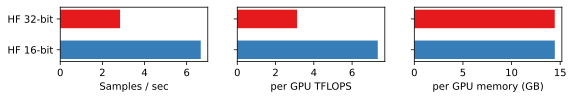

In [10]:
bert_half = hf_bert(Exp('HF 16-bit', 'bert-large-uncased', 5, fp16=True))
compare([bert_single, bert_half])

You may be surprised that using 16-bit floating points doesn't reduce memory size by half under the same hyperparameters. That's because 
the memory usage is mainly due to three parts: model parameters, layer outputs in the forward path (activations) and workspace memory used by backend libraries. 16-bit floats do not save memory related to model parameters because model updating is running with 32-bit. For one model parameter: 


- with 32-bit, we use 4 bytes for the 32-bit weight, 4 bytes for the 32-bit gradient, 8 bytes for the two momentums in Adam, a total of **16 bytes**
- with 32-bit, we use 2 bytes for the 16-bit weight, 2 bytes for the 16-bit gradient (some implementation uses 32-bit gradient), 4 bytes for the master 32-bit weight, and 8 bytes for the two momentums in adam, with a total of **16 bytes** 

The memory saving is due to all activations are stored in 16-bit. As the activation size is linear to the batch size and sequence length, using 16-bit could allow you to double batch size or sequence length. 

GPUs using old architectures before Ampere do not support `bf16`, you could try to use `fp16` via changing the above code to `fp16=True`. It often offers same performance as `bf16`, but may require you to tune the [loss scaling](https://moocaholic.medium.com/fp64-fp32-fp16-bfloat16-tf32-and-other-members-of-the-zoo-a1ca7897d407).

As we shown in the micro-benchmarks, the model updating that involving multiple vector operators could be expensive. If you have [apex](https://github.com/NVIDIA/apex) installed, we can use an faster implementation. 

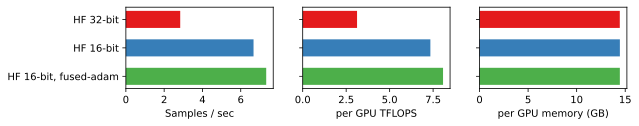

In [11]:
bert_half_fused = hf_bert(Exp(
    'HF 16-bit, fused-adam', 'bert-large-uncased', 5, fp16=True, optim='adamw_apex_fused'))
compare([bert_single, bert_half, bert_half_fused])

To further reduce the optimization overhead, we can accumulate the gradients multiple times before updating weight. If we accumulate 4 times, then it leads to an 4x larger effective batch size. It may be too big for the fine tuning task, but often not a problem for pre-training.

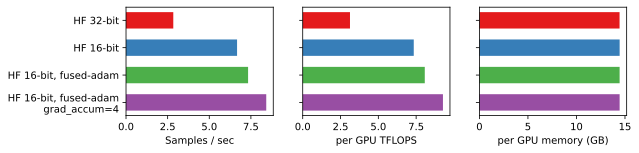

In [12]:
bert_half_fused_accum = hf_bert(Exp(
    'HF 16-bit, fused-adam\ngrad_accum=4', 'bert-large-uncased', 5, fp16=True, 
    optim='adamw_apex_fused', grad_accum=4, steps=5))
compare([bert_single, bert_half, bert_half_fused, bert_half_fused_accum])

If your model is too big so not sufficient memory is left for activations, we can throw away them and then re-compute when needed. It can be also used to increase the micro batch size. 

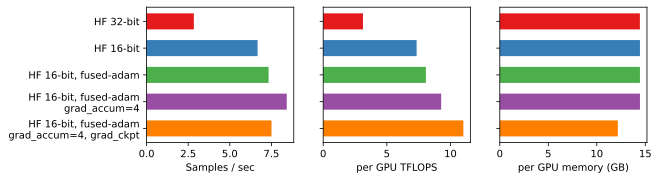

In [14]:
bert_half_fused_accum_ckpt = hf_bert(Exp(
    'HF 16-bit, fused-adam\ngrad_accum=4, grad_ckpt', 'bert-large-uncased', 25, fp16=True, 
    optim='adamw_apex_fused', grad_accum=4, grad_ckpt=True, steps=5))
compare([bert_single, bert_half, bert_half_fused, bert_half_fused_accum, bert_half_fused_accum_ckpt])

Though it furthers improve TFLOPS, but decreases the number of samples per second because of the extra forward. So use it only when the model is very big you cannot use an effective batch size. 

## BERT on a Single GPU with Megatron-LM

Though `HuggingFace` is the most popular package for transformers, it's not the fastest one. Here let's use Megatron-LM from Nvidia. First download vocab and a sample dataset. 

In [ ]:
!wget -nc https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt
!wget -nc https://github.com/mli/transformers-benchmarks/raw/main/data/bert-sample_text_sentence.bin
!wget -nc https://github.com/mli/transformers-benchmarks/raw/main/data/bert-sample_text_sentence.idx
    
clear_output()

Define the function to run BERT and parse its log.

In [5]:
def megatron_bert(exp):
    cmd = f'''{exp.launcher} Megatron-LM/pretrain_bert.py \
--num-layers {exp.num_layers} --hidden-size {exp.hidden_size} \
--num-attention-heads {exp.num_heads} \
--tensor-model-parallel-size {exp.tensor_para} \
--micro-batch-size {exp.batch_size} \
--seq-length {exp.seq_len} --max-position-embeddings {exp.seq_len} \
--train-iters {exp.steps} \
--data-path bert-sample_text_sentence \
--vocab-file bert-large-uncased-vocab.txt \
--data-impl mmap --lr 0.00015 --log-interval 5'''
    if exp.bf16: cmd += ' --bf16'
    if exp.fp16: cmd += ' --fp16'
    cmd += ' > log.txt 2>&1'
    os.system(cmd)
    return megatron_log(exp, 'log.txt') 
    
def megatron_log(exp, log_filename):
    with open(log_filename) as f:
        text = f.read()
    # Find the last number after the key, returns 0 if not exists
    query = lambda key: float(next(iter(        
        reversed(re.findall(key+': +([\d\.]+)', text))), 0))
    if 'CUDA out of memory' in text:
        print('Out of GPU memory, try a smaller batch size')
        return
    iter_time = query('elapsed time per iteration \(ms\)') 
    if iter_time == 0:
        print(f'Failed. Check "{log_filename}" to find error')
        return
    exp.samples_per_sec = query('global batch size') / iter_time * 1e3
    exp.gpu_mem = query('max allocated')/1e3
    print('Time breakdown\t\t: forward+backward %.2f, communication %.2f, optimizer %.2f' %(
        (query('forward-compute')+query('backward-compute')) / iter_time, 
        query('backward-params-all-reduce') / iter_time, query('optimizer') / iter_time))        
    return exp

Run BERT large again.

Time breakdown		: forward+backward 0.87, communication 0.01, optimizer 0.11


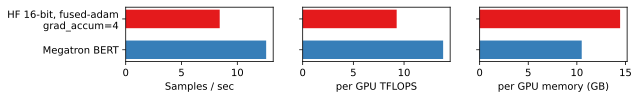

In [25]:
mega_bert = megatron_bert(Exp('Megatron BERT', 'bert-large-uncased', 8, fp16=True))
compare([bert_half_fused_accum, mega_bert])

Note that Megatron allows to use a larger batch size and outperforms Huggingface even without gradient accumulation. One reason is the highly efficient [custom kernels](https://github.com/NVIDIA/Megatron-LM/tree/main/megatron/fused_kernels) that not only improve performance but also reduce memory usage. 

## GPT-2 on a Single GPU

Next we train language model with GPT-2. First define the function to use HuggingFace.

In [6]:
def hf_gpt(exp):
    cmd = f'''export CUDA_VISIBLE_DEVICES={exp.gpus}; \
{exp.launcher} transformers/examples/pytorch/language-modeling/run_clm.py \
--config_name {exp.model} --tokenizer_name {exp.model} \
--dataset_name wikitext --dataset_config_name wikitext-2-raw-v1 \
--do_train --per_device_train_batch_size {exp.batch_size} \
--block_size {exp.seq_len} --learning_rate 2e-5 \
--max_steps {exp.steps} --optim {exp.optim} \
--fp16 {exp.fp16} --bf16 {exp.bf16} \
--gradient_accumulation_steps {exp.grad_accum} \
--gradient_checkpointing {exp.grad_ckpt} \
--output_dir /tmp/gpt/ --overwrite_output_dir yes --skip_memory_metrics False'''
    if exp.deepspeed:
        cmd += f' --deepspeed {exp.ds_config}'
    cmd += ' > log.txt 2>&1'
    os.system(cmd)
    return hf_log(exp, 'log.txt')

We use `gpt2-medium` whose architecture is similar to `bert-large`. GPT-2 models uses a larger sequence length 1024.

In [28]:
hf_gpt2 = hf_gpt(Exp(
    "HF GPT2", "gpt2-medium", 1, fp16=True, optim='adamw_apex_fused', grad_accum=4))
hf_gpt2.print_results()

Total samples / second	: 2.2
Per GPU memory (GB)	: 13.2
Per GPU TFLOPs		: 5.3


Let's try Megatron's implementation.

In [7]:
def megatron_gpt(exp):
    global_batch_size = exp.batch_size * exp.num_gpus * exp.grad_accum / exp.tensor_para
    cmd = f'''{exp.launcher} Megatron-LM/pretrain_gpt.py \
--num-layers {exp.num_layers} --hidden-size {exp.hidden_size} \
--num-attention-heads {exp.num_heads} \
--tensor-model-parallel-size {exp.tensor_para} \
--micro-batch-size {exp.batch_size} --global-batch-size {int(global_batch_size)} \
--seq-length {exp.seq_len} --max-position-embeddings {exp.seq_len} \
--train-iters {exp.steps} --data-path gpt2-sample_text_document \
--vocab-file gpt2-vocab.json --merge-file gpt2-merges.txt \
--data-impl mmap --lr 0.00015 --log-interval 5 '''
    cmd += '--bf16 ' if exp.bf16 else ''
    cmd += '--fp16 ' if exp.fp16 else ''
    cmd += ' > log.txt 2>&1'
    os.system(cmd)
    return megatron_log(exp, 'log.txt') 

Downloads data for Megatron

In [30]:
!wget -nc https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-vocab.json
!wget -nc https://s3.amazonaws.com/models.huggingface.co/bert/gpt2-merges.txt    
!wget -nc https://github.com/mli/transformers-benchmarks/raw/main/data/gpt2-sample_text_document.bin
!wget -nc https://github.com/mli/transformers-benchmarks/raw/main/data/gpt2-sample_text_document.idx
    
clear_output()

Again, Megatron allows a larger batch size and outperforms Huggingface.

Time breakdown		: forward+backward 0.78, communication 0.01, optimizer 0.20


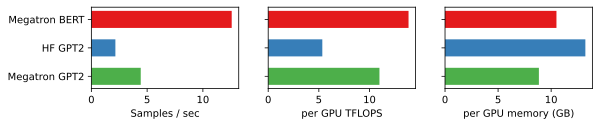

In [31]:
mega_gpt2 = megatron_gpt(Exp("Megatron GPT2", "gpt2-medium", 2, fp16=True))
compare([mega_bert, hf_gpt2, mega_gpt2])

## Multiple GPUs with Data Parallelism

Let's first check how GPUs are connected. 

In [8]:
!nvidia-smi topo -m

	GPU0	GPU1	CPU Affinity	NUMA Affinity
GPU0	 X 	PHB	0-47		N/A
GPU1	PHB	 X 	0-47		N/A

Legend:

  X    = Self
  SYS  = Connection traversing PCIe as well as the SMP interconnect between NUMA nodes (e.g., QPI/UPI)
  NODE = Connection traversing PCIe as well as the interconnect between PCIe Host Bridges within a NUMA node
  PHB  = Connection traversing PCIe as well as a PCIe Host Bridge (typically the CPU)
  PXB  = Connection traversing multiple PCIe bridges (without traversing the PCIe Host Bridge)
  PIX  = Connection traversing at most a single PCIe bridge
  NV#  = Connection traversing a bonded set of # NVLinks


You can use we have two GPUs connected by NVLinks. Besides, they are also connected through PCIe 4.0 x8.

You can use the [p2pBandwidthLatencyTest](https://github.com/NVIDIA/cuda-samples/tree/master/Samples/5_Domain_Specific/p2pBandwidthLatencyTest) tool to get a rough estimation of the bandwidth. Here are our results:

```bash
Unidirectional P2P=Disabled Bandwidth Matrix (GB/s)
   D\D     0      1
     0 891.84   6.23
     1   6.23 893.88
Unidirectional P2P=Enabled Bandwidth (P2P Writes) Matrix (GB/s)
   D\D     0      1
     0 883.27  52.77
     1  52.89 894.39
Bidirectional P2P=Disabled Bandwidth Matrix (GB/s)
   D\D     0      1
     0 884.77   9.20
     1   9.24 900.06
Bidirectional P2P=Enabled Bandwidth Matrix (GB/s)
   D\D     0      1
     0 885.52 101.36
     1 101.52 900.84
```

Now let's run GPT-2 with Megatron on two GPUs, which use data parallelism in default. (You can replace with `hf_gpt` as well.) 

Time breakdown		: forward+backward 0.54, communication 0.29, optimizer 0.17


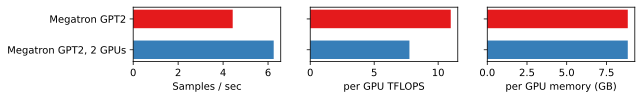

In [34]:
dp_gpt2 = megatron_gpt(Exp("Megatron GPT2, 2 GPUs", "gpt2-medium", 2, fp16=True, gpus='0,1'))
compare([mega_gpt2, dp_gpt2])

From the time breakdown, you can see the communication takes 10\%, which is almost 0 on a single GPU. It leads to a reduced per GPU TFLOPS. 

If we disable NVLink to use PCIe instead, the performance decreases.

In [ ]:
# 没有nvlink就不做对比
os.environ["NCCL_P2P_DISABLE"] = "1"
dp_gpt2_nonvlink = megatron_gpt(Exp(
    "Megatron GPT2, 2 GPUs\nno nvlink", "gpt2-medium", 2, fp16=True, gpus='0,1'))
os.environ["NCCL_P2P_DISABLE"] = "0"
compare([mega_gpt2, dp_gpt2, dp_gpt2_nonvlink])

One improvement idea is using gradient accumulation to reduce communication frequency.

Time breakdown		: forward+backward 0.83, communication 0.10, optimizer 0.06


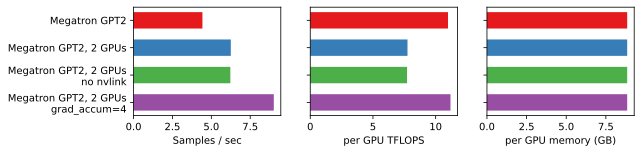

In [36]:
dp_gpt2_accum = megatron_gpt(Exp(
    "Megatron GPT2, 2 GPUs\ngrad_accum=4", "gpt2-medium", 2, fp16=True, gpus='0,1', grad_accum=4))
compare([mega_gpt2, dp_gpt2, dp_gpt2_nonvlink, dp_gpt2_accum])

A 4 accumulation reduce the communication cost from 10\% to 3\%. It helps more when using PCIe, the cost reduces from 37\% to 14\%. 

In [ ]:
# 没有nvlink就不做对比
os.environ["NCCL_P2P_DISABLE"] = "1"
dp_gpt2_accum_nonvlink = megatron_gpt(Exp(
    "Megatron GPT2, 2 GPUs\ngrad_accum=4, no nvlink", "gpt2-medium", 
    2, fp16=True, gpus='0,1', grad_accum=4))
os.environ["NCCL_P2P_DISABLE"] = "0"
compare([mega_gpt2, dp_gpt2, dp_gpt2_nonvlink, dp_gpt2_accum, dp_gpt2_accum_nonvlink])

## Multiple GPUs with Tensor Parallelism

Different to data parallelism (DP) that splits data, tensor parallelism (TP) partitions each layer into multiple GPUs. So we can use a larger batch size per GPU. 

Time breakdown		: forward+backward 0.92, communication 0.00, optimizer 0.07


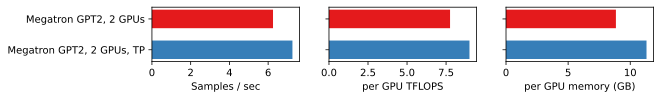

In [38]:
tp_gpt2 = megatron_gpt(Exp(
    "Megatron GPT2, 2 GPUs, TP", "gpt2-medium", 6, fp16=True, gpus='0,1', tensor_para=2))
compare([dp_gpt2, tp_gpt2])

TP offers a similar performance as DP. But note that communication happens in both forward and backward for TP, the time breakdown doesn't show the communication cost correctly. It also means gradient accumulation helps TP little. 

Time breakdown		: forward+backward 0.99, communication 0.00, optimizer 0.00


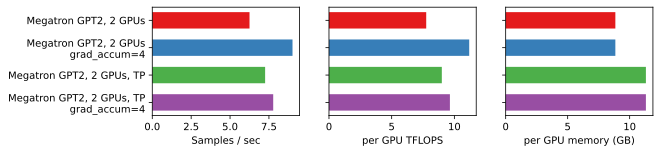

In [39]:
tp_gpt2_accum = megatron_gpt(Exp(
    "Megatron GPT2, 2 GPUs, TP\ngrad_accum=4", "gpt2-medium", 6, fp16=True, gpus='0,1',
    tensor_para=2, grad_accum=4, steps=10))
compare([dp_gpt2, dp_gpt2_accum, tp_gpt2, tp_gpt2_accum])

One benefit of TP is that we can run very large model that's impossible for DP (at least without gradient accumulation). Let's try a 1.3B GPT. 

Time breakdown		: forward+backward 0.98, communication 0.00, optimizer 0.02


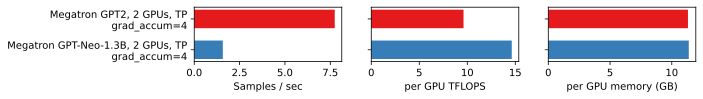

In [11]:
tp_gpt_neo_accum = megatron_gpt(Exp(
    "Megatron GPT-Neo-1.3B, 2 GPUs, TP\ngrad_accum=4", "EleutherAI/gpt-neo-1.3B", 1, fp16=True, gpus='0,1',
    tensor_para=2, grad_accum=4, steps=10))
compare([tp_gpt2_accum, tp_gpt_neo_accum])

## Multiple GPU with ZeRO

Similar to TP, ZeRO also enables run very large model. Here we try Zero-2.

In [ ]:
zero2_gpt_neo_accum = hf_gpt(Exp(
    "HF GPT-Neo-1.3B, 2 GPUs, zero-2\ngrad_accum=16", "EleutherAI/gpt-neo-1.3B", 1, fp16=True, gpus='0,1',
    optim='adamw_apex_fused', grad_accum=16,
    steps=5, deepspeed=True,  ds_config='transformers/tests/deepspeed/ds_config_zero2.json'))
compare([tp_gpt_neo_accum, zero2_gpt_neo_accum])

#### Out of GPU memory~~, 无奈双T4在ZeRO连1个batch都跑不起, 只能下期换个大内存的双卡再战

## Conclusion

1. To get a good performance we need to use **a sufficient large batch size** for better operator performance and reducing the cost ratio of communication and parameter updating. All large GPU memory size, reduced precision data types, kernel fusion, gradient accumulation, and gradient checkpoints help. Though a too large batch size affects convergence, especially for fine-tuning or pre-training with hundreds of GPUs. 

1. Data parallelism works well if your model fits into a single GPU. Otherwise you can use tensor parallelism and ZeRO.

## Exercises

1. Evaluate this notebook on your GPU machines. You may need to tune the batch size to fit into your memory.
1. Try to use a smaller batch size, check how it affect TFLOPS.
1. Try to use pipeline parallelism in Megatron.
1. Try to use deepspeed with Megatron
1. Try to use DP with gradient checkpoint for `GPT-Neo-1.3B`
1. Try to benchmark T5, which has both encoder and decoder.
1. Try the largest model in you ran in your machine.
1. Estimate the time you need to train `gpt2-medium` on 1 billion tokens.